In [ ]:
# List of modules that are not installed in the course
!pip install OpenPermID
!pip install geocoder
!pip install matplotlib
!pip install xlrd==1.2.0
!pip install xlsxwriter
!pip install sklearn
!pip install ipywidgets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Downloading all bonds ever owned in CSPP

In [2]:
from functions import downloadECBBonds

In [3]:
holdingsECB = downloadECBBonds.download_ECB_Bonds()

# Read all the Eikon data

In [4]:
from functions import readEikonData
eikon_data_complete = readEikonData.get_eikon_data_complete()
eligible_complete = readEikonData.get_data_eligible_complete() # read all data from eligible universe

Compare how many bonds from the eligible universe the ECB bought.

In [5]:
overlap = eikon_data_complete[(eikon_data_complete["ISIN"].isin(eligible_complete["ISIN"]))]
print("the percentage of bonds bought by ECB in eligible universe that we have info on:    ", 
      overlap.shape[0]/eligible_complete.shape[0])

the percentage of bonds bought by ECB in eligible universe that we have info on:     0.16143170197224252


Read the dates

In [6]:
years_issuer_bought = readEikonData.get_dates_data_frame()

# ECB green bonds that are listed on Euronext stock exchange 

TODO: make 1 function in .py file

In [7]:
#reading data of green bonds listed on Euronext 
euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)
#Getting the ISIN of the Euronext green bonds 
euronext_greenbond_isin = euronext_greenbonds["ISIN"]
#Comparing the ISINs of the ECB and Euronext green bonds and returning matches 
ecbgreenbonds = holdingsECB[(holdingsECB["ISIN"].isin(euronext_greenbond_isin))]

<ipython-input-7-e360e4db16fe>:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)


TODO: calculate percentage green before and after 2020

# Company Analysis based on ESG scores

## Cleaning the ESG data

In [8]:
from functions import ESG
print("for eligible universe:")
esg_company_data_eligible = ESG.cleaning_esg_data(eligible_complete)
print("for holdings in the CSPP:")
esg_company_data_holdings = ESG.cleaning_esg_data(eikon_data_complete)

for eligible universe:
nb of rows without ESG scores:  139
percentage of rows without ESG scores:  0.6405529953917051
nb of nans filled in using interpolation:  152
percentage of nans filled in using interpolation:  0.08755760368663594
for holdings in the CSPP:
nb of rows without ESG scores:  216
percentage of rows without ESG scores:  0.5837837837837838
nb of nans filled in using interpolation:  266
percentage of nans filled in using interpolation:  0.08986486486486486


## ESG Evolution of holdings through the years

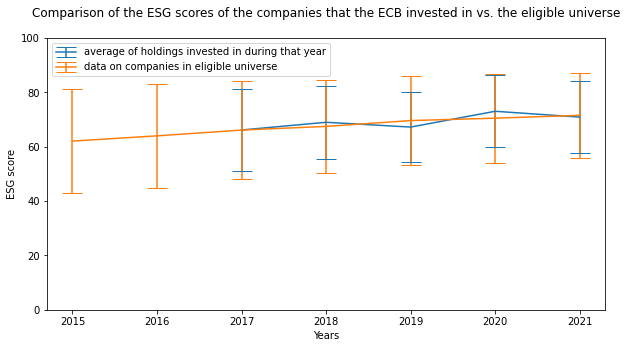

In [9]:
ESG.average_company_esg_score_plot(years_issuer_bought, esg_company_data_holdings,esg_company_data_eligible)

# Sector Analysis

## Get all sector data from PermID

In [10]:
from functions import permidSectors
sector_mappings = permidSectors.get_sector_mappings(holdingsECB)
sector_mappings.dropna(inplace = True)

c:\Users\Maarten\OneDrive\school\2020-2021\bMLSOD\Modern Data Analytics\project\ECB-Bond-Purchases\functions\permidSectors.py:119: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  sector_mappings = pd.read_excel(parent+'\output\sector_mappings_data.xlsx', header=0)


## Represent industries and sectors

Create a pie chart to represent the number of times an industry, sector or supersector is present in the data (multiple bonds for the same company are counted separately)

In [11]:
from functions import pieCharts

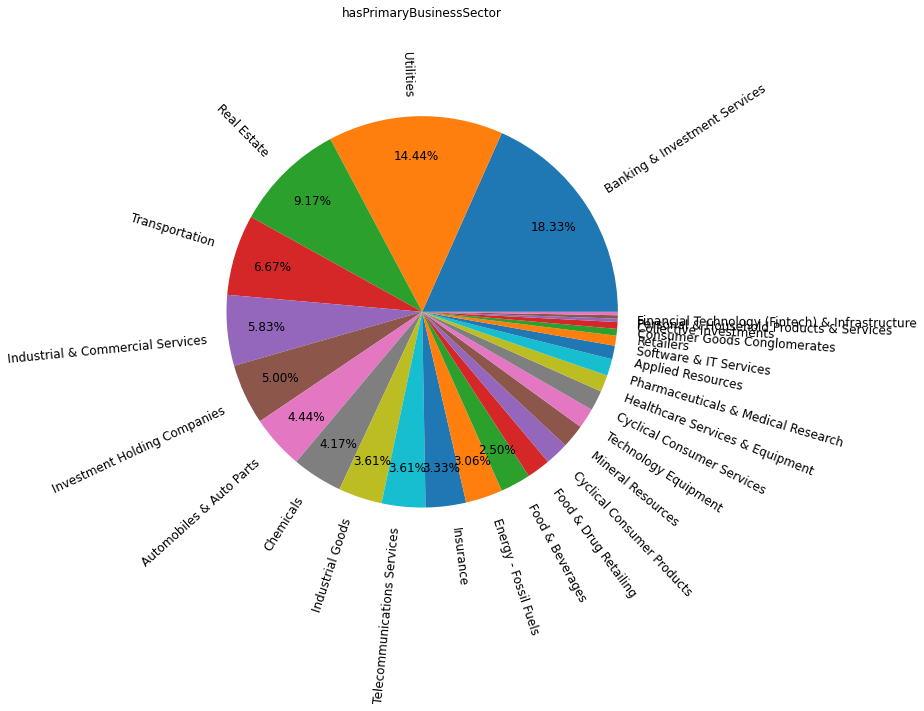

In [12]:
pieCharts.make_pie_chart('hasPrimaryBusinessSector', sector_mappings)

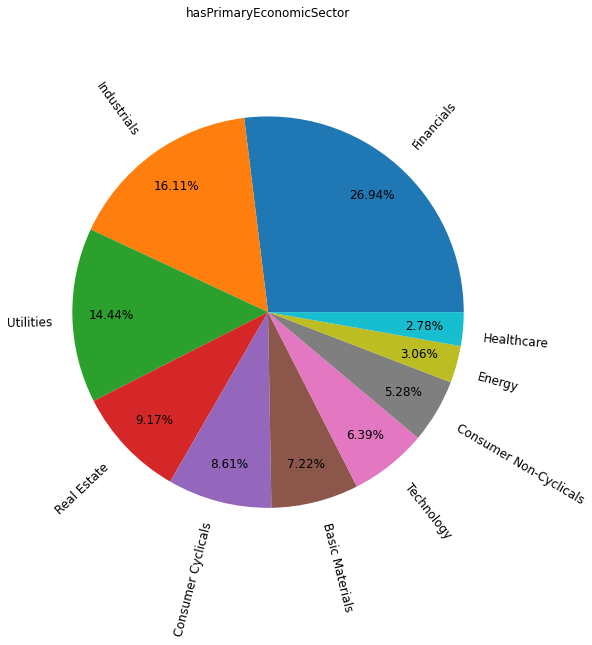

In [13]:
pieCharts.make_pie_chart('hasPrimaryEconomicSector', sector_mappings)

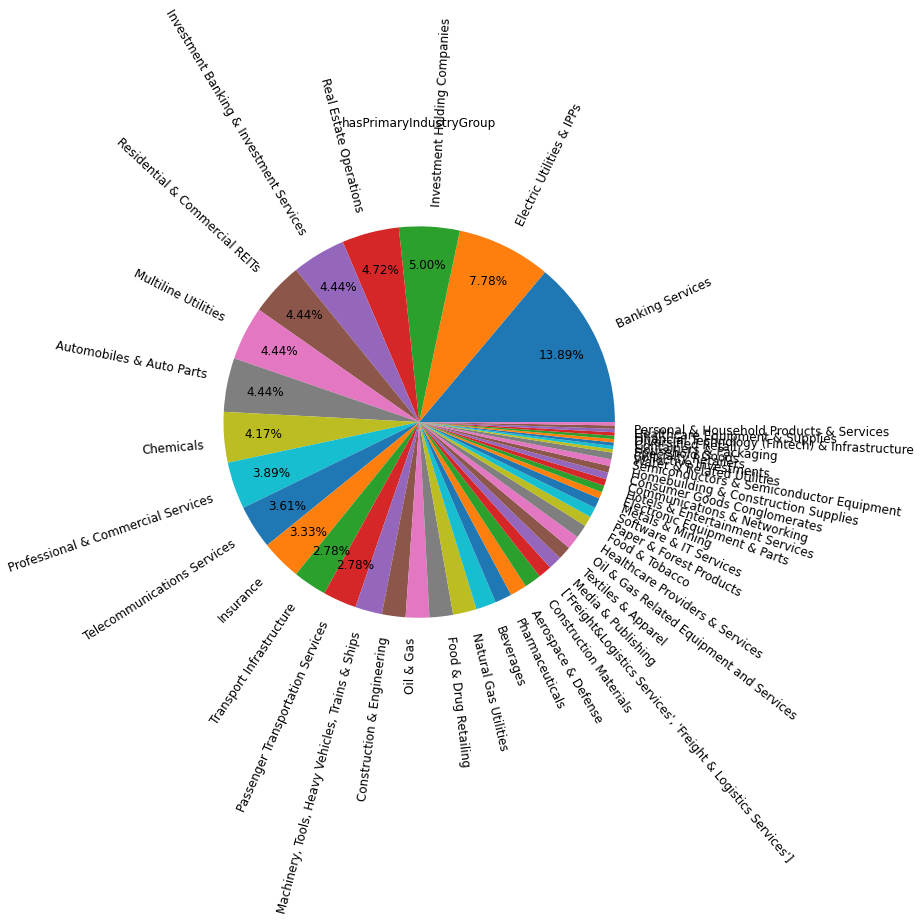

In [14]:
pieCharts.make_pie_chart('hasPrimaryIndustryGroup', sector_mappings)

## Which industries and sectors are green?

Map the dictionary with greenness of all PermID sectors with the ones in which ECB invested



In [15]:
from functions import sectors
sector_green_dict = sectors.get_sector_green_dict()

In [16]:
primary_business_sector = pieCharts.get_all_sectors("hasPrimaryBusinessSector", sector_mappings)
primary_business_sector = sectors.map_green_dict_to_data_frame(primary_business_sector)

- Total Count for each sector overall and compare these sectors (we view as “bad”, like cement, oil&gas or with kaggle dataset(emission))
- Similar approach but per year → do we see a change in habit, total counts → differences in the sectors 
- For the sectors: make spaghetti plot with for each sector the percentage invested in every year (in app: select which sectors you want)
    - Include in app (can view all, and have “buttons” to choose what to show) 
    - Make percentages instead of absolute counts
    - Remove before 2017

In [17]:
sector_mappings["Greenness"] = sector_mappings["hasPrimaryBusinessSector"].dropna().apply(lambda x: sector_green_dict[x])

c:\Users\Maarten\OneDrive\school\2020-2021\bMLSOD\Modern Data Analytics\project\ECB-Bond-Purchases\functions\sectors.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors_spaghetti_data_frame[sector][i] = year_x_count_sector[str(i+2017)]


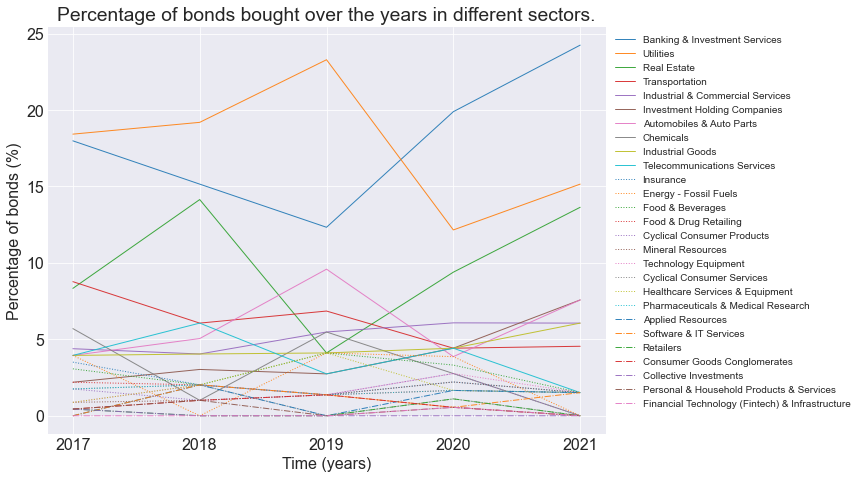

In [18]:
# Draw a spaghetti plot for all the sectors
sectors.draw_spaghetti_plot_sectors(primary_business_sector, sector_mappings, years_issuer_bought)

c:\Users\Maarten\OneDrive\school\2020-2021\bMLSOD\Modern Data Analytics\project\ECB-Bond-Purchases\functions\sectors.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors_spaghetti_data_frame[sector][i] = year_x_count_sector[str(i+2017)]


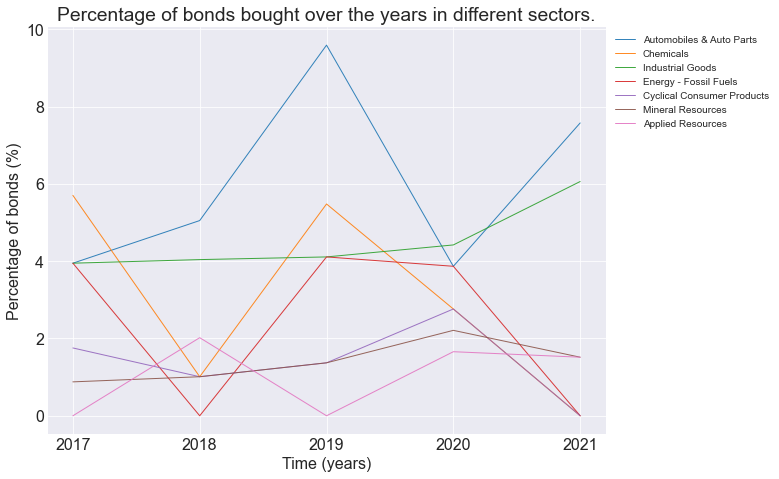

In [19]:
# Draw a spaghetti plot for the grey sectors
grey_sectors = primary_business_sector[primary_business_sector["green"]==-1].index
sectors.draw_spaghetti_plot_sectors(primary_business_sector, sector_mappings, years_issuer_bought, grey_sectors)

c:\Users\Maarten\OneDrive\school\2020-2021\bMLSOD\Modern Data Analytics\project\ECB-Bond-Purchases\functions\sectors.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors_spaghetti_data_frame[sector][i] = year_x_count_sector[str(i+2017)]


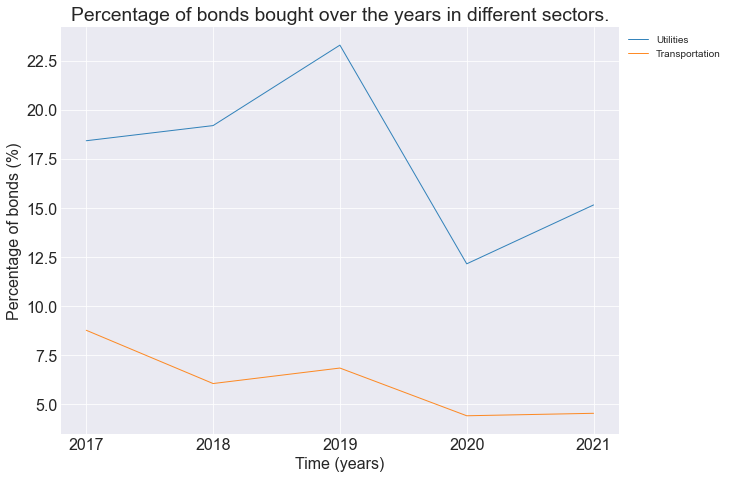

In [20]:
# Draw a spaghetti plot for the green sectors
green_sectors = primary_business_sector[primary_business_sector["green"]==1].index
sectors.draw_spaghetti_plot_sectors(primary_business_sector, sector_mappings, years_issuer_bought, green_sectors)

c:\Users\Maarten\OneDrive\school\2020-2021\bMLSOD\Modern Data Analytics\project\ECB-Bond-Purchases\functions\sectors.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors_spaghetti_data_frame[sector][i] = year_x_count_sector[str(i+2017)]


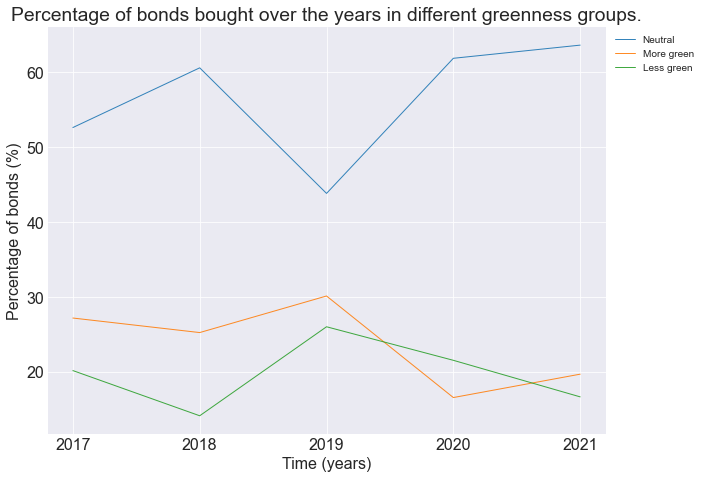

In [21]:
# Drawing a sphagetti plot by grouping sectors according to greenness
green_dict = {-1: "Less green", 0: "Neutral", 1: "More green"}
sector_mappings_modified = sector_mappings.copy()
sector_mappings_modified["hasPrimaryBusinessSector"] = sector_mappings_modified.Greenness.apply(lambda x: green_dict[x])
levels_of_greenness = pieCharts.get_all_sectors("hasPrimaryBusinessSector", sector_mappings_modified)
levels_of_greenness = sectors.map_green_dict_to_data_frame(levels_of_greenness)
sectors.draw_spaghetti_plot_sectors(levels_of_greenness, sector_mappings_modified, years_issuer_bought, title = "greenness groups")